# MELTS v. 1.2.0
  
Versions of MELTS implemented are:  
- MELTS v. 1.0.2 ➞ (rhyolite-MELTS, Gualda et al., 2012)  
- MELTS v. 1.1.0 ➞ (rhyolite-MELTS + new CO<sub>2</sub>, works at the ternary minimum)  
- MELTS v. 1.2.0 ➞ (rhyolite-MELTS + new H<sub>2</sub>O + new CO<sub>2</sub>)  
- pMELTS v. 5.6.1

## Initialize tools and packages that are required to execute this notebook.

In [1]:
from thermoengine import equilibrate
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import pandas as pd
%matplotlib inline

## Create a MELTS v 1.2.0 instance.
Rhyolite-MELTS version 1.0.2 is the default model.

In [2]:
melts = equilibrate.MELTSmodel('1.2.0')
# melts = equilibrate.MELTSmodel('1.0.2')

### Optional: Generate some information about the implemented model.

In [3]:
oxides = melts.get_oxide_names()
phases = melts.get_phase_names()
#print (oxides)
#print (phases)

## Required: Input initial composition of the system (liquid), in wt% or grams of oxides. 


In [4]:
#Fe2O3 Calc 
def Fe2O3Calc(FeOwt, Fe3FeT_ratio):
    FeO = FeOwt * (1 - Fe3FeT_ratio)
    Fe2O3 = FeOwt * (Fe3FeT_ratio) * 1.11 # 1.11 converts for molar mass diferences
    return FeO, Fe2O3

In [8]:
DMM_Melting_Model_df = pd.read_excel("DMM_Melting_Dynamic-Fractional_Melting_model_110ppmH2O-10percentFe3.xlsx", sheet_name= "Potential Temp 1373C")
DMM_Melting_Model_df.columns

Index(['step', 'status', 'T_C', 'P_MPa', 'total_mass_g', 'liquid_mass_g',
       'liquid_fraction', 'frac_liq_coeff', 'mass_Liquid', 'mass_Olivine',
       'mass_Orthopyroxene', 'mass_Augite', 'mass_Spinel', 'liq_oxide_SiO2',
       'liq_oxide_TiO2', 'liq_oxide_Al2O3', 'liq_oxide_Fe2O3',
       'liq_oxide_Cr2O3', 'liq_oxide_FeO', 'liq_oxide_MnO', 'liq_oxide_MgO',
       'liq_oxide_NiO', 'liq_oxide_CoO', 'liq_oxide_CaO', 'liq_oxide_Na2O',
       'liq_oxide_K2O', 'liq_oxide_P2O5', 'liq_oxide_H2O',
       'liq_oxide_FeOTotal', 'liq_oxide_SiO2_accumulated',
       'liq_oxide_TiO2_accumulated', 'liq_oxide_Al2O3_accumulated',
       'liq_oxide_Fe2O3_accumulated', 'liq_oxide_Cr2O3_accumulated',
       'liq_oxide_FeO_accumulated', 'liq_oxide_MnO_accumulated',
       'liq_oxide_MgO_accumulated', 'liq_oxide_NiO_accumulated',
       'liq_oxide_CoO_accumulated', 'liq_oxide_CaO_accumulated',
       'liq_oxide_Na2O_accumulated', 'liq_oxide_K2O_accumulated',
       'liq_oxide_P2O5_accumulated', 'liq_

In [107]:
# FeO, Fe2O3 = Fe2O3Calc(8.18,0.1)
# melt_composition = {'SiO2':  50.21, 
#                                        'TiO2':   1.7, 
#                                        'Al2O3':  15.16, 
#                                     #    'Fe2O3':  Fe2O3,#  # Need to calcuate ferric iron for models to run properly Assumed 4%
#                                        'FeO':    10.29, # Total Feo 8.18 wt% 
#                                        'MnO':    0.0, #0.13 Excluded for modeling
#                                        'MgO':   8.08, 
#                                     #    'NiO':    0.0, #0.24 Excluded 
#                                     #    'CoO':    0.0,
#                                        'CaO':    11.58, 
#                                        'Na2O':   2.53, 
#                                        'K2O':    0.12, 
#                                        # 'P2O5':   0.0, #
#                                     #    'H2O':    0.2, }) # 0.011 Water included 110 ppm
# }

# 500 mpa
# FeO, Fe2O3 = Fe2O3Calc(8.18,0.1)
melt_composition = {'SiO2':  47.35, 
                                       'TiO2':   0.45, 
                                       'Al2O3':  13.28, 
                                    #    'Fe2O3':  Fe2O3,#  # Need to calcuate ferric iron for models to run properly Assumed 4%
                                       'FeO':    10.29, # Total Feo 8.18 wt% 
                                       'MnO':    0.0, #0.13 Excluded for modeling
                                       'MgO':   16.72, 
                                    #    'NiO':    0.0, #0.24 Excluded 
                                    #    'CoO':    0.0,
                                       'CaO':    10.6, 
                                       'Na2O':   0.91, 
                                       'K2O':    0.02, 
                                       'Cr2O3': 0.06
                                       # 'P2O5':   0.0, #
                                    #    'H2O':    0.2, }) # 0.011 Water included 110 ppm
}


def set_melt_composition(comp_dict_init, Fe3FeT_ratio, H2O_wt, melts_object = melts):
    # Assumes all iron is input as FeO modify this if needed
    comp_dict = deepcopy(comp_dict_init)
    FeO, Fe2O3 = Fe2O3Calc(comp_dict['FeO'],Fe3FeT_ratio) 
    comp_dict.update([("FeO",FeO), ("Fe2O3", Fe2O3), ("H2O",H2O_wt)])
    # Set bulk composition in Melts
    melts_object.set_bulk_composition(comp_dict) # 0.011 Water included 110 ppm

True

In [ ]:
def melt_composition_from_df(df,
                             row=0,
                             oxide_col_prefix='liq_oxide_',
                             oxide_col_suffix='_accumulated',
                             h2o_wt=None,
                             oxides_list=None):
    """
    Build a melt_composition dict formatted for set_melt_composition(...)
    - df: dataframe with accumulated liquid oxide compositions
    - row: index label or integer position to take from df
    - oxide_col_prefix: if df columns are named like 'liq_oxide_SiO2' (default)
    - oxide_col_suffix: if df columns are named like 'liq_oxide_SiO2_accumulted' (default)
    - fe3fe_ratio: (unused for combining Fe if both FeO and Fe2O3 present) kept for API compatibility
    - h2o_wt: optional override for H2O in output dict
    - oxides_list: optional list of oxide names to include (defaults to global `oxides` if present)
    Returns: dict with oxide wt% suitable as input to set_melt_composition (uses 'FeO' as total Fe in FeO-equivalent)
    """
    # determine oxide names to output
    if oxides_list is None:
        oxides_list = globals().get('oxides',
                                    ['SiO2', 'TiO2', 'Al2O3', 'Fe2O3', 'Cr2O3',
                                     'FeO', 'MnO', 'MgO', 'NiO', 'CoO', 'CaO',
                                     'Na2O', 'K2O', 'P2O5', 'H2O', 'CO2'])

    # select row (by label if possible, else by integer position)
    # I may modify this to directly take a series
    try:
        row_ser = df.loc[row]
    
    except Exception:
        row_ser = df.iloc[row]

    # collect values from df
    values = {}
    # prefer prefixed columns if present
    prefixed_cols = [c for c in df.columns if c.startswith(oxide_col_prefix) and c.endswith(oxide_col_suffix)]
    if prefixed_cols:
        for c in prefixed_cols:
            ox = c[len(oxide_col_prefix):-len(oxide_col_suffix)]
            values[ox] = float(row_ser.get(c, 0.0))
    else:
        for c in df.columns:
            if c in oxides_list:
                values[c] = float(row_ser.get(c, 0.0))

    # compute total Fe as FeO-equivalent:
    feo_val = float(values.get('FeO', 0.0))
    fe2o3_val = float(values.get('Fe2O3', 0.0))
    # if both present, convert Fe2O3 to FeO-equivalent and add
    if fe2o3_val:
        feo_from_fe2o3 = fe2o3_val / 1.11
        # if FeO also present in dataframe that likely is FeO portion; sum to get total Fe as FeO-equivalent
        feo_val = feo_val + feo_from_fe2o3

    # build output dict in same style as previous cell (omit Fe2O3; set FeO as total Fe-in-FeO-form)
    comp = {}
    for ox in oxides_list:
        if ox == 'Fe2O3':
            # skip explicit Fe2O3: set_melt_composition will re-create Fe2O3 from FeO + Fe3/FeT ratio
            continue
        if ox == 'FeO':
            comp['FeO'] = float(feo_val)
        else:
            comp[ox] = float(values.get(ox, 0.0))

    # H2O override if provided
    if h2o_wt is not None:
        comp['H2O'] = float(h2o_wt)

    return comp

# Example usage with the existing dataframe:
# melt_comp = melt_composition_from_df(DMM_Melting_Model_df, row=0, oxide_col_prefix='liq_oxide_')
# set_melt_composition(melt_comp, Fe3FeT_ratio=0.1, H2O_wt=melt_comp.get('H2O', 0.011))
melt_comp = melt_composition_from_df(DMM_Melting_Model_df, row=30, oxide_col_prefix='liq_oxide_')
melt_comp

SiO2
TiO2
Al2O3
Fe2O3
Cr2O3
FeO
MnO
MgO
NiO
CoO
CaO
Na2O
K2O
P2O5
H2O
FeOTotal


{'SiO2': 43.27776064900922,
 'TiO2': 0.8282390819516098,
 'Al2O3': 13.76317507109779,
 'Cr2O3': 0.05858114836938275,
 'FeO': 12.075350534986091,
 'MnO': 0.0,
 'MgO': 17.0889307948514,
 'NiO': 0.0,
 'CoO': 0.0,
 'CaO': 7.541344965781646,
 'Na2O': 4.547052690509553,
 'K2O': 0.1769047383927453,
 'P2O5': 0.0,
 'H2O': 0.3243253537200341,
 'CO2': 0.0}

In [28]:
# melt_comp = melt_composition_from_df(DMM_Melting_Model_df, row=10, oxide_col_prefix='liq_oxide_')
# melt_comp
DMM_Melting_Model_df.iloc[10]

step                                                           10
status                            success, Optimal residual norm.
T_C                                                   1417.847458
P_MPa                                                 2500.166667
total_mass_g                                             99.84698
liquid_mass_g                                            0.779876
liquid_fraction                                          0.007811
frac_liq_coeff                                                0.0
mass_Liquid                                              0.779876
mass_Olivine                                            54.333696
mass_Orthopyroxene                                      23.105895
mass_Augite                                             15.791283
mass_Spinel                                              3.127083
liq_oxide_SiO2                                           41.04119
liq_oxide_TiO2                                           0.858419
liq_oxide_

In [19]:
# set_melt_composition(melt_composition, Fe3FeT_ratio=0.1, H2O_wt=0.011)

## Optional: Suppress phases that are not required in the simulation.

In [109]:
b = melts.get_phase_inclusion_status()
# melts.set_phase_inclusion_status({'Nepheline':False, 'OrthoOxide':False})
a = melts.get_phase_inclusion_status()
for phase in b.keys():
    if b[phase] != a[phase]:
        print ("{0:<15s} Before: {1:<5s} After: {2:<5s}".format(phase, repr(b[phase]), repr(a[phase])))

## Compute the equilibrium state at some specified T (°C) and P (MPa).
Print status of the calculation.

In [110]:
output = melts.equilibrate_tp(1300.0, 100.0, initialize=True)
(status, t, p, xmlout) = output[0]
print (status, t, p)

success, Trivial case with no quadratic search. 1300.0 100.0


### Summary output of equilibrium state ...

In [111]:
melts.output_summary(xmlout)

T (°C)      1300.00
P (MPa)      100.00
Plagioclase       0.4621 (g)  K0.00Na0.16Ca0.84Al1.84Si2.16O8                             
Olivine           0.1391 (g)  (Ca0.01Mg0.77Fe''0.23Mn0.00Co0.00Ni0.00)2SiO4               
Liquid           44.3506 (g)  wt%:SiO2 50.33 TiO2  0.97 Al2O3 13.82 Fe2O3  2.12 Cr2O3  0.00 FeO 12.03 MnO  0.00 MgO  7.37 NiO
                                   0.00 CoO  0.00 CaO 11.08 Na2O  1.35 K2O  0.04 P2O5  0.00 H2O  0.90 CO2  0.00
Augite            0.3418 (g)  Na0.01Ca0.67Fe''0.26Mg0.95Fe'''0.05Ti0.01Al0.18Si1.89O6     


If running a model with fractionation you can se the fractionated phase here. and the coefficients of the fractionation model.

In [112]:
# frac_coeff = melts.get_dictionary_of_default_fractionation_coefficients(fracLiq=True, fracSolid=False, fracFluid=False, fracCoeff=1.) % Removes liquid\
frac_coeff = melts.get_dictionary_of_default_fractionation_coefficients(fracLiq=False, fracSolid=True, fracFluid=False, fracCoeff=1.) # Removes solids
# frac_coeff = melts.get_dictionary_of_default_fractionation_coefficients(fracLiq=False, fracSolid=True, fracFluid=False, fracCoeff=0.5) # Removes solids
print (frac_coeff)

{'Actinolite': 1.0, 'Aegirine': 1.0, 'Aenigmatite': 1.0, 'Akermanite': 1.0, 'Andalusite': 1.0, 'Anthophyllite': 1.0, 'Apatite': 1.0, 'Augite': 1.0, 'Biotite': 1.0, 'Chromite': 1.0, 'Coesite': 1.0, 'Corundum': 1.0, 'Cristobalite': 1.0, 'Cummingtonite': 1.0, 'Fayalite': 1.0, 'Fluid': 0.0, 'Forsterite': 1.0, 'Garnet': 1.0, 'Gehlenite': 1.0, 'Hematite': 1.0, 'Hornblende': 1.0, 'Ilmenite': 1.0, 'Ilmenite ss': 1.0, 'Kalsilite': 1.0, 'Kalsilite ss': 1.0, 'Kyanite': 1.0, 'Leucite': 1.0, 'Lime': 1.0, 'Liquid': 0.0, 'Liquid Alloy': 1.0, 'Magnetite': 1.0, 'Melilite': 1.0, 'Muscovite': 1.0, 'Nepheline': 1.0, 'Nepheline ss': 1.0, 'Olivine': 1.0, 'OrthoOxide': 1.0, 'Orthopyroxene': 1.0, 'Panunzite': 1.0, 'Periclase': 1.0, 'Perovskite': 1.0, 'Phlogopite': 1.0, 'Pigeonite': 1.0, 'Plagioclase': 1.0, 'Quartz': 1.0, 'Rutile': 1.0, 'Sanidine': 1.0, 'Sillimanite': 1.0, 'Solid Alloy': 1.0, 'Sphene': 1.0, 'Spinel': 1.0, 'Titanaugite': 1.0, 'Tridymite': 1.0, 'Whitlockite': 1.0}


### Output thermodynamic properties of any phase present in the system
... or the sum of all phases in the system

In [113]:
props = melts.get_list_of_properties()
for prop in props:
    print ("{0:<20s} {1:13.6e} {2:<10s}".format(prop, melts.get_property_of_phase(xmlout,'System', prop), \
                                                melts.get_units_of_property(prop)))

Mass                  4.529359e+01 g         
GibbsFreeEnergy      -7.296717e+05 J         
Enthalpy             -5.294670e+05 J         
Entropy               1.272380e+02 J/K       
HeatCapacity          6.729123e+01 J/K       
DcpDt                 2.109812e-04 J/K^2     
Volume                1.699215e+00 J/bar     
DvDt                  1.271020e-04 J/bar-K   
DvDp                 -9.488121e-06 J/bar^2   
D2vDt2                3.619982e-10 J/bar-K^2 
D2vDtDp               1.037461e-09 J/bar^2-K 
D2vDp2                2.136601e-10 J/bar^3   
Density               2.665560e+00 g/cm^3    
Alpha                 7.480041e-05 1/K       
Beta                  5.583827e-06 1/bar     
K                     1.790886e+01 GPa       
K'                    3.032843e+00 none      
Gamma                 2.073261e-01 none      


### Output chemical affinities and potential compositions of undersaturated phases 

In [114]:
dict = melts.get_dictionary_of_affinities(xmlout, sort=True)
for phase in dict:
    (affinity, formulae) = dict[phase]
    print ("{0:<20s} {1:10.2f} {2:<60s}".format(phase, affinity, formulae))

Quartz                  7774.58 SiO2                                                        
Orthopyroxene           8087.27 Na0.00Ca1.00Fe''0.83Mg0.00Fe'''0.07Ti0.00Al0.27Si1.83O6     
Cristobalite            8599.07 SiO2                                                        
Tridymite               8599.64 SiO2                                                        
Forsterite             12758.93 Mg2SiO4                                                     
Spinel                 14664.66 Fe''0.29Mg0.75Fe'''0.43Al1.50Cr0.00Ti0.03O4                 
Coesite                17047.98 SiO2                                                        
Ilmenite ss            22931.58 Mn0.00Fe''0.53Mg0.00Fe'''0.00Al0.93Ti0.53O3                 
Fluid                  24012.81 X:H2O 0.000 CO2 1.000                                       
Corundum               25075.97 Al2O3                                                       
Periclase              30074.19 MgO                                   

## Run the sequence of calculations along a T, P=constant path:
Output is sent to an Excel file and plotted in the notebook

In [115]:
def run_batch_melting(t0,
            t_f,
            p0,
            p_f=1,
            n_steps=40,
            # t_step=-10,
            # p_step=-0,
            melts_obj=melts,
            frac_coeff = frac_coeff,
            Fractionate = False,
            track_phases=None,
            write_excel=False,
            excel_filename="Melts_summary.xlsx",
            sheet_name="Summary"):
    """
        Run a batch sequence along a specified P-T path.

        Parameters:
        - t0, p0: initial temperature (°C) and pressure (MPa)
        - n_steps: number of steps (including initial)
        - t_step, p_step: increments applied at each step (can be negative)
        - melts_obj: MELTS model object (uses global `melts` by default)
        - track_phases: list of phase names to record masses (defaults to common set)
        - write_excel: whether to create/update/write an Excel workbook via melts methods
        - excel_filename, sheet_name: workbook parameters when write_excel=True

        Returns:
        - df: pandas.DataFrame with recorded step data (T, P, masses, liquid fractions, oxide wt% of liquid, frac_coeff_liq)
        - params: dictionary with run parameters
    """
    p_array = np.linspace(p0,p_f, n_steps)
    # t_step = t_step/p_step * pstep
    
    t_array = np.linspace(t0,t_f, n_steps)

    # defaults
    if track_phases is None:
        track_phases = ['Liquid', 'Olivine', 'Orthopyroxene', 'Augite', 'Spinel', 'Plagioclase']

    # oxide list (use existing variable if present)
    try:
        oxide_list = oxides
    except NameError:
        oxide_list = melts_obj.get_oxide_names()

    # prepare storage
    rows = []

    # optional excel workbook
    wb = None
    if write_excel:
        wb = melts_obj.start_excel_workbook_with_sheet_name(sheetName=sheet_name)

    # initial equilibrium
    # output = melts_obj.equilibrate_tp(t0, p0, initialize=True)
    # (status, t, p, xmlout) = output[0]

    # loop steps
    # for step in range(n_steps):
    for idx, p in enumerate(p_array):
        t = t_array[idx]
        output = melts_obj.equilibrate_tp(t, p, initialize=True)
        
        (status, _, _, xmlout) = output[0]
        # compute masses and fractions
        total_mass = melts_obj.get_mass_of_phase(xmlout)
        liquid_mass = melts_obj.get_mass_of_phase(xmlout, phase_name="Liquid")
        liquid_fraction = (liquid_mass / total_mass) if total_mass and total_mass != 0 else 0.0



        # record tracked phase masses
        phase_masses = {ph: melts_obj.get_mass_of_phase(xmlout, phase_name=ph) for ph in track_phases}

        # record liquid composition (wt% oxides)
        liquid_comp = melts_obj.get_composition_of_phase(xmlout, phase_name='Liquid', mode='oxide_wt')

        # ensure all oxides present
        liquid_comp_full = {ox: float(liquid_comp.get(ox, 0.0)) for ox in oxide_list}


        # append row
        row = {
            'step': idx,
            'status': status,
            'T_C': t,
            'P_MPa': p,
            'total_mass_g': total_mass,
            'liquid_mass_g': liquid_mass,
            'liquid_fraction': liquid_fraction,
        
        }
        # add phase masses
        for ph, m in phase_masses.items():
            row[f'mass_{ph}'] = m
        # add oxide wt% of liquid
        for ox, v in liquid_comp_full.items():
            row[f'liq_oxide_{ox}'] = v

        rows.append(row)

        # update excel if requested
        if write_excel:
            melts_obj.update_excel_workbook(wb, xmlout)

        

        print(f"T:{t}, P:{p}")

        if (idx < len(p_array) - 1) * Fractionate:
            melts_obj.fractionate_phases(xmlout, frac_coeff)

    # finalize excel
    if write_excel:
        melts_obj.write_excel_workbook(wb, excel_filename)


    # build dataframe
    df = pd.DataFrame(rows)

    params = {
        'initial_T_C': t0,
        'initial_P_MPa': p0,
        'n_steps': n_steps,
        # 't_step': t_step,
        # 'p_step': p_step,
        'tracked_phases': track_phases,
        'oxide_list': oxide_list,
    }
    df['liq_oxide_FeOTotal'] = df["liq_oxide_FeO"] + df['liq_oxide_Fe2O3']/1.11

    return df, params

In [ ]:
# set_melt_composition(melt_composition, Fe3FeT_ratio=0.1, H2O_wt=0.04)
set_melt_composition(melt_composition, Fe3FeT_ratio=0.1, H2O_wt=0.4) # Liquid compositions don't look very normal unless we use a higher initial H2O concentration. This makes sense given that there will be shallow degassing for measured MORBs but hard probably means we need more H2O in the output of our DMM melting models
p = 100
output_dict = run_batch_melting(t0 = 1380,
            t_f= 1140,
            p0 = 500,
            p_f=50,
            n_steps=80,
            # t_step=-10,
            # p_step=-0,
            melts_obj=melts,
            frac_coeff = frac_coeff,
            Fractionate = True,
            track_phases=None,
            write_excel=False,
            excel_filename="Melts_summary.xlsx",
            sheet_name="Summary")

T:1380.0, P:500.0
T:1376.9620253164558, P:494.30379746835445
T:1373.9240506329113, P:488.60759493670884
T:1370.886075949367, P:482.9113924050633
T:1367.8481012658228, P:477.2151898734177
T:1364.8101265822784, P:471.5189873417722
T:1361.7721518987341, P:465.82278481012656
T:1358.73417721519, P:460.126582278481
T:1355.6962025316457, P:454.43037974683546
T:1352.6582278481012, P:448.7341772151899
T:1349.620253164557, P:443.0379746835443
T:1346.5822784810127, P:437.34177215189874
T:1343.5443037974683, P:431.6455696202531
T:1340.506329113924, P:425.9493670886076
T:1337.4683544303798, P:420.253164556962
T:1334.4303797468353, P:414.55696202531647
T:1331.392405063291, P:408.8607594936709
T:1328.3544303797469, P:403.1645569620253
T:1325.3164556962024, P:397.46835443037975
T:1322.2784810126582, P:391.7721518987342
T:1319.240506329114, P:386.0759493670886
T:1316.2025316455697, P:380.37974683544303
T:1313.1645569620252, P:374.6835443037975
T:1310.126582278481, P:368.9873417721519
T:1307.08860759493

In [117]:
df, params = output_dict
df.columns

Index(['step', 'status', 'T_C', 'P_MPa', 'total_mass_g', 'liquid_mass_g',
       'liquid_fraction', 'mass_Liquid', 'mass_Olivine', 'mass_Orthopyroxene',
       'mass_Augite', 'mass_Spinel', 'mass_Plagioclase', 'liq_oxide_SiO2',
       'liq_oxide_TiO2', 'liq_oxide_Al2O3', 'liq_oxide_Fe2O3',
       'liq_oxide_Cr2O3', 'liq_oxide_FeO', 'liq_oxide_MnO', 'liq_oxide_MgO',
       'liq_oxide_NiO', 'liq_oxide_CoO', 'liq_oxide_CaO', 'liq_oxide_Na2O',
       'liq_oxide_K2O', 'liq_oxide_P2O5', 'liq_oxide_H2O', 'liq_oxide_CO2',
       'liq_oxide_FeOTotal'],
      dtype='object')

In [118]:
df[['step', 'status', 'T_C', 'P_MPa', 'total_mass_g', 'liquid_mass_g',
       'liquid_fraction', 'mass_Liquid', 'mass_Olivine', 'mass_Orthopyroxene',
       'mass_Augite', 'mass_Spinel', 'mass_Plagioclase']].iloc[30:80]

,step,status,T_C,P_MPa,total_mass_g,liquid_mass_g,liquid_fraction,mass_Liquid,mass_Olivine,mass_Orthopyroxene,mass_Augite,mass_Spinel,mass_Plagioclase
30,30,"success, Optimal residual norm.",1288.860759,329.113924,88.234417,87.971743,0.997023,87.971743,0.262673,0.0,0.000000,0.000000,0.000000
31,31,"success, Optimal residual norm.",1285.822785,323.417722,87.971743,87.711539,0.997042,87.711539,0.260204,0.0,0.000000,0.000000,0.000000
32,32,"success, Optimal residual norm.",1282.784810,317.721519,87.711539,87.453773,0.997061,87.453773,0.257766,0.0,0.000000,0.000000,0.000000
33,33,"success, Optimal residual norm.",1279.746835,312.025316,87.453773,87.198416,0.997080,87.198416,0.255358,0.0,0.000000,0.000000,0.000000
34,34,"success, Optimal residual norm.",1276.708861,306.329114,87.198416,86.945437,0.997099,86.945437,0.252979,0.0,0.000000,0.000000,0.000000
35,35,"success, Optimal residual norm.",1273.670886,300.632911,86.945437,86.690031,0.997062,86.690031,0.250585,0.0,0.000000,0.004821,0.000000
36,36,"success, Minimal energy computed.",1270.632911,294.936709,86.690031,86.436211,0.997072,86.436211,0.248251,0.0,0.000000,0.005569,0.000000
37,37,"success, Optimal residual norm.",1267.594937,289.240506,86.436211,86.184696,0.997090,86.184696,0.245953,0.0,0.000000,0.005562,0.000000
38,38,"success, Minimal energy computed.",1264.556962,283.544304,86.184696,85.935459,0.997108,85.935459,0.243682,0.0,0.000000,0.005555,0.000000
39,39,"success, Optimal residual norm.",1261.518987,277.848101,85.935459,85.688471,0.997126,85.688471,0.241440,0.0,0.000000,0.005548,0.000000


In [119]:
# df[['step', 'status', 'T_C', 'P_MPa', 'total_mass_g', 'liquid_mass_g',
#        'liquid_fraction', 'mass_Liquid', 'mass_Olivine', 'mass_Orthopyroxene',
#        'mass_Augite', 'mass_Spinel', 'mass_Plagioclase']]
df['plag/aug']=df['mass_Plagioclase']/ df['mass_Augite']
df['plag/ol']=df['mass_Plagioclase']/ df['mass_Olivine']
df[['step', 'status', 'T_C', 'P_MPa', 'total_mass_g', 'liquid_mass_g',
       'liquid_fraction', 'mass_Liquid', 'mass_Olivine', 'mass_Orthopyroxene',
       'mass_Augite', 'mass_Spinel', 'mass_Plagioclase', 'plag/aug', 'plag/ol']]


,step,status,T_C,P_MPa,total_mass_g,liquid_mass_g,liquid_fraction,mass_Liquid,mass_Olivine,mass_Orthopyroxene,mass_Augite,mass_Spinel,mass_Plagioclase,plag/aug,plag/ol
0,0,"success, Optimal residual norm.",1380.000000,500.000000,100.193190,97.083654,0.968965,97.083654,3.109536,0.0,0.000000,0.000000,0.000000,NaN,0.000000
1,1,"success, Minimal energy computed.",1376.962025,494.303797,97.083654,96.733496,0.996393,96.733496,0.350158,0.0,0.000000,0.000000,0.000000,NaN,0.000000
2,2,"success, Optimal residual norm.",1373.924051,488.607595,96.733496,96.386955,0.996418,96.386955,0.346541,0.0,0.000000,0.000000,0.000000,NaN,0.000000
3,3,"success, Optimal residual norm.",1370.886076,482.911392,96.386955,96.043981,0.996442,96.043981,0.342974,0.0,0.000000,0.000000,0.000000,NaN,0.000000
4,4,"success, Optimal residual norm.",1367.848101,477.215190,96.043981,95.704524,0.996466,95.704524,0.339456,0.0,0.000000,0.000000,0.000000,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,75,"success, Minimal energy computed.",1152.151899,72.784810,49.610647,48.476307,0.977135,48.476307,0.161299,0.0,0.418019,0.002596,0.552424,1.321527,3.424834
76,76,"success, Minimal energy computed.",1149.113924,67.088608,48.476307,47.393239,0.977658,47.393239,0.154887,0.0,0.398062,0.002655,0.527464,1.325078,3.405478
77,77,"success, Minimal energy computed.",1146.075949,61.392405,47.393239,46.357994,0.978156,46.357994,0.148974,0.0,0.379374,0.002715,0.504182,1.328986,3.384376
78,78,"success, Minimal energy computed.",1143.037975,55.696203,46.357994,45.367432,0.978632,45.367432,0.143522,0.0,0.361832,0.002777,0.482431,1.333303,3.361371


<Axes: xlabel='T_C'>

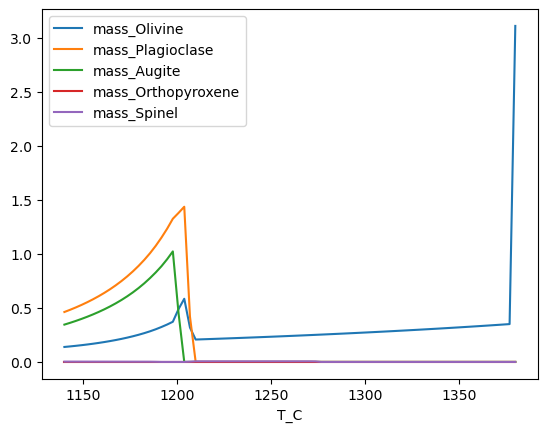

In [120]:
fig, ax = plt.subplots()
df.plot('T_C', 'mass_Olivine', ax = ax)
df.plot('T_C', 'mass_Plagioclase', ax = ax)
df.plot('T_C', 'mass_Augite', ax = ax)
df.plot('T_C', 'mass_Orthopyroxene', ax = ax)
df.plot('T_C', 'mass_Spinel', ax = ax)
# plt.ylim(0,20)

In [121]:
df.columns

Index(['step', 'status', 'T_C', 'P_MPa', 'total_mass_g', 'liquid_mass_g',
       'liquid_fraction', 'mass_Liquid', 'mass_Olivine', 'mass_Orthopyroxene',
       'mass_Augite', 'mass_Spinel', 'mass_Plagioclase', 'liq_oxide_SiO2',
       'liq_oxide_TiO2', 'liq_oxide_Al2O3', 'liq_oxide_Fe2O3',
       'liq_oxide_Cr2O3', 'liq_oxide_FeO', 'liq_oxide_MnO', 'liq_oxide_MgO',
       'liq_oxide_NiO', 'liq_oxide_CoO', 'liq_oxide_CaO', 'liq_oxide_Na2O',
       'liq_oxide_K2O', 'liq_oxide_P2O5', 'liq_oxide_H2O', 'liq_oxide_CO2',
       'liq_oxide_FeOTotal', 'plag/aug', 'plag/ol'],
      dtype='object')

<Axes: xlabel='T_C'>

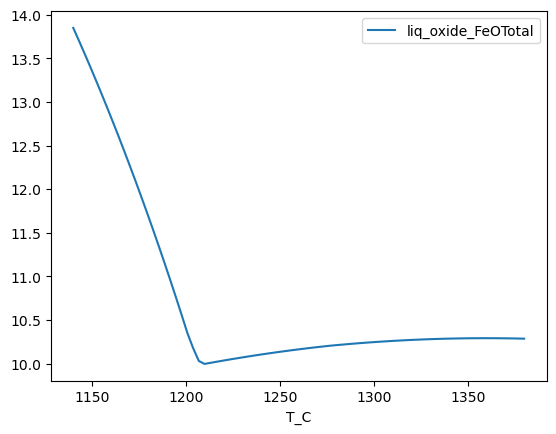

In [122]:
fig, ax = plt.subplots()
df.plot('T_C', 'liq_oxide_FeOTotal', ax = ax)

<Axes: xlabel='liq_oxide_MgO'>

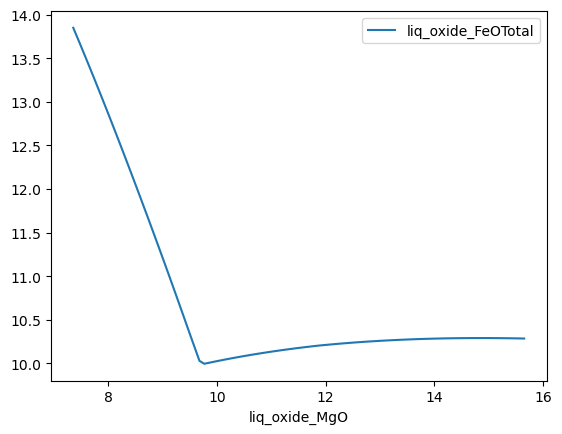

In [123]:
fig, ax = plt.subplots()
df.plot('liq_oxide_MgO', 'liq_oxide_FeOTotal', ax = ax)

<Axes: xlabel='T_C'>

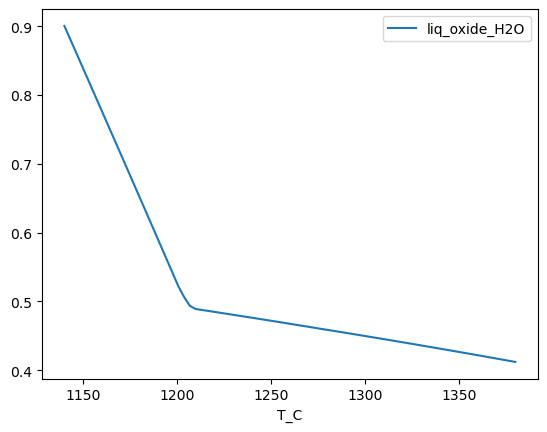

In [124]:
fig, ax = plt.subplots()
df.plot('T_C', 'liq_oxide_H2O', ax = ax)

<Axes: xlabel='T_C'>

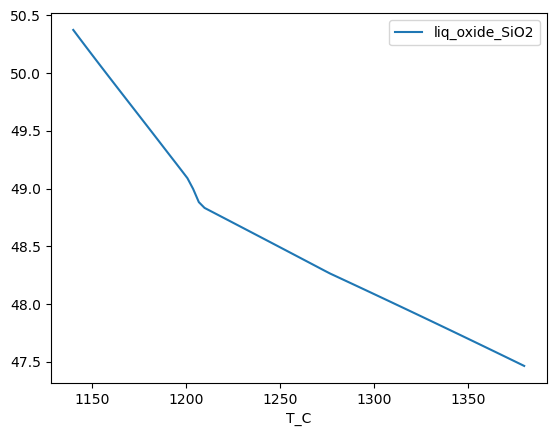

In [125]:
fig, ax = plt.subplots()
df.plot('T_C', 'liq_oxide_SiO2', ax = ax)

<Axes: xlabel='T_C'>

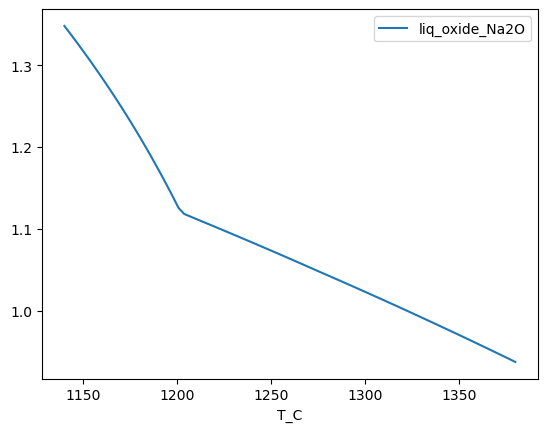

In [126]:
fig, ax = plt.subplots()
df.plot('T_C', 'liq_oxide_Na2O', ax = ax)

<Axes: xlabel='T_C'>

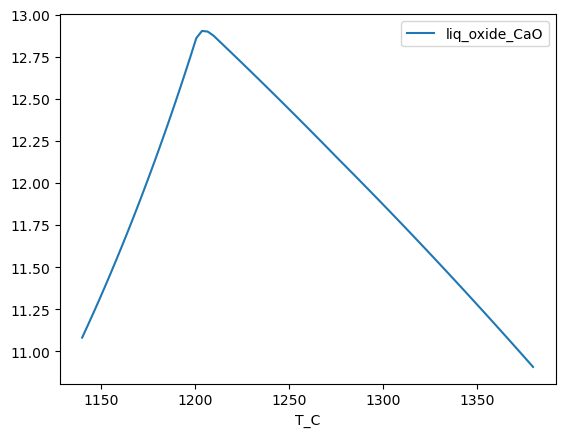

In [127]:
fig, ax = plt.subplots()
df.plot('T_C', 'liq_oxide_CaO', ax = ax)

<Axes: xlabel='T_C'>

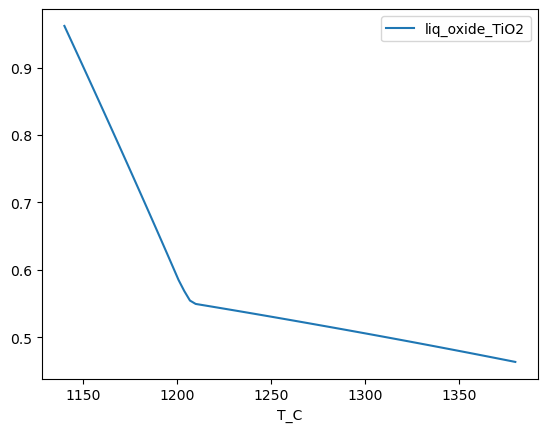

In [128]:
fig, ax = plt.subplots()
df.plot('T_C', 'liq_oxide_TiO2', ax = ax)

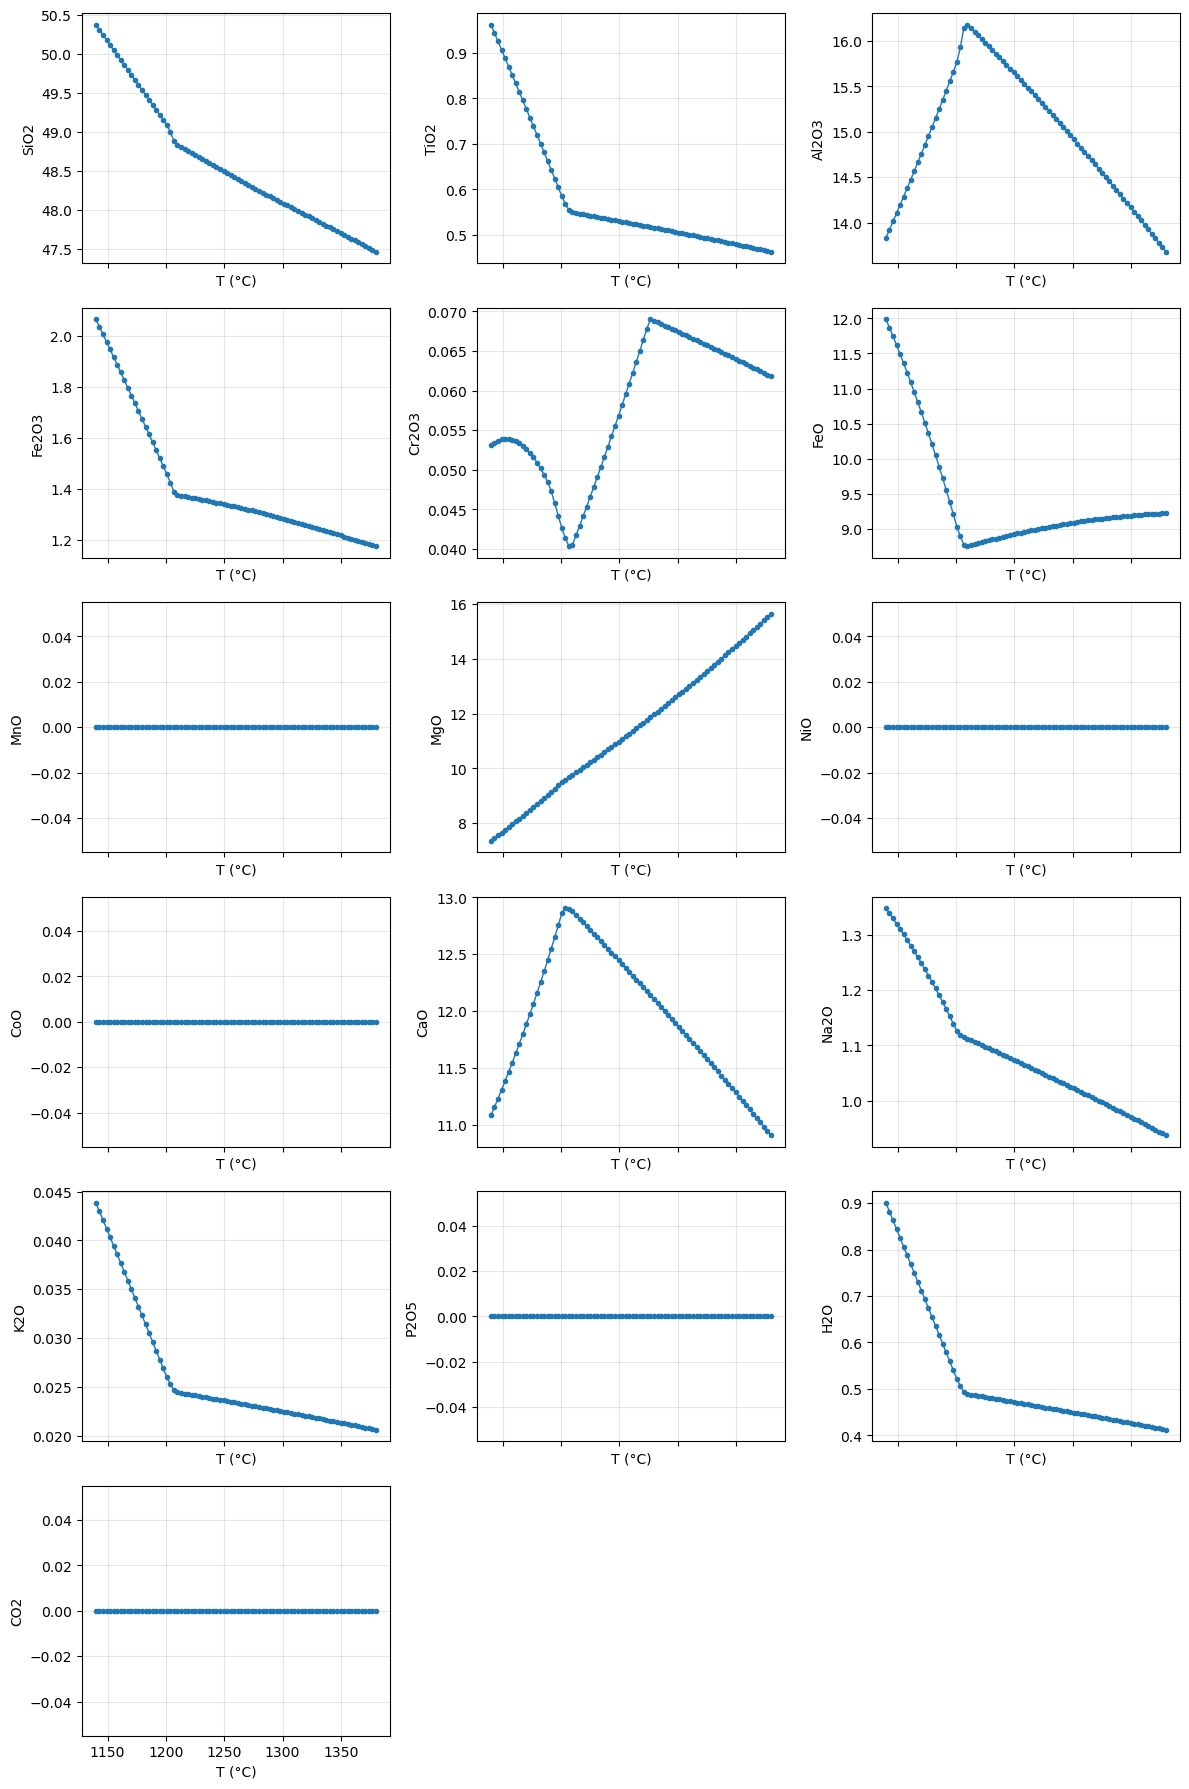

In [129]:
# plot liquid oxide wt% vs Temperature (T_C) as a grid of subplots
cols = [c for c in df.columns if c.startswith('liq_oxide_')]
# Need to drop certain elements which arent modeled CO2, MnO, CoO, NiO,P2O5

# prefer ordering by melts oxide list if available
try:
    ordered = [f'liq_oxide_{ox}' for ox in oxides if f'liq_oxide_{ox}' in df.columns]
    cols = ordered if ordered else cols
except NameError:
    pass

n = len(cols)
if n == 0:
    raise RuntimeError("No 'liq_oxide_' columns found in df")

ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=True)
axes = np.array(axes).reshape(-1)  # flatten

for i, col in enumerate(cols):
    ax = axes[i]
    ax.plot(df['T_C'], df[col], marker='.', linewidth=1)
    ox_name = col.replace('liq_oxide_', '')
    ax.set_ylabel(ox_name)
    ax.set_xlabel('T (°C)')
    ax.grid(alpha=0.3)

# hide any unused axes
for j in range(n, axes.size):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

<Axes: xlabel='T_C'>

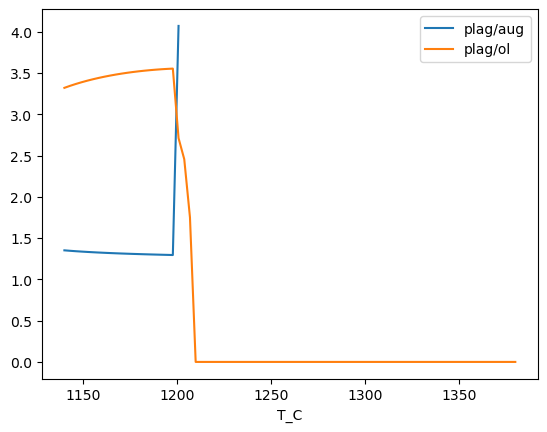

In [55]:
fig, ax = plt.subplots()
df.plot('T_C', 'plag/aug', ax = ax)
df.plot('T_C', 'plag/ol', ax = ax)
# plt.ylim(0,2)